# Clustering Two Features

**Project Goal:** A model to cluster two features. A unsupervised model to segment the two categories of households - the credit fearful and the credit fearless groups, and to examine the differences between the two clusters. Also to examine the mean charactristics of the two clusters.

In [20]:
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.utils.validation import check_is_fitted

### Prepare Data

Import

- We create and use wrangle() function that takes a path of a CSV file as input, reads the file into a DataFrame, subsets the data to households that have been turned down for credit or feared being denied credit in the past 5 years (see "TURNFEAR"), and returns the subset DataFrame.

In [11]:
def wrangle(filepath):
    df=pd.read_csv(filepath)
    mask = df["TURNFEAR"] == 1
    df_fear = df[mask]
    
    return df

In [13]:
df=wrangle("data/customer.csv")
print("df type:", type(df))
print("df shape:", df.shape)
df.head()

df type: <class 'pandas.core.frame.DataFrame'>
df shape: (28885, 351)


,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


Explore

Scatter Plot. Home Value vs Debt

- Here we explore the relationship between real estate and debt for the credit fearful households.

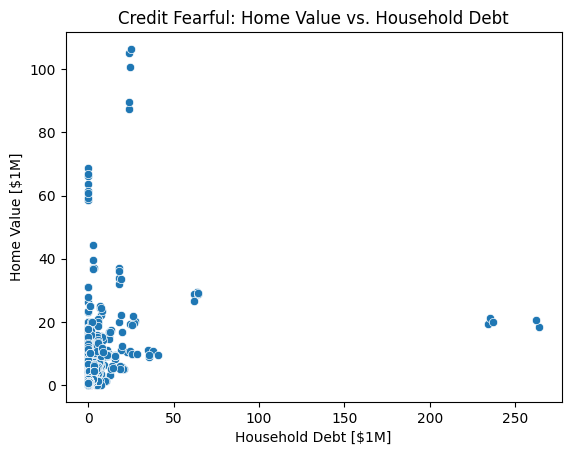

In [31]:
# Plot "HOUSES" vs "DEBT"
sns.scatterplot(x=(df["DEBT"]/1e6), y=(df["HOUSES"]/1e6))
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

Split

Vertical split

In [16]:
X = df[["DEBT", "HOUSES"]]

print("X type:", type(X))
print("X shape:", X.shape)
X.head()

X type: <class 'pandas.core.frame.DataFrame'>
X shape: (28885, 2)


,DEBT,HOUSES
0,0.0,1100000.0
1,0.0,1100000.0
2,0.0,1100000.0
3,0.0,1100000.0
4,0.0,1100000.0


### Build Model

**Unsupervised Learning & KMeans** - Has no target matrix, only the feature matrix.

- Cluster households based on their proximity to eachh other. 
- K in KMeans is the number of clusters - a hyperparamter.
- A centroid represents the mean value of all the data in the cluster, we would expect it to fall in the center of whatever cluster it's in.

Iterate

In [22]:
# Build model
model = KMeans(n_clusters=3,random_state=42)
print("model type:", type(model))

# Fit model to data
model.fit(X)

model type: <class 'sklearn.cluster._kmeans.KMeans'>


KMeans(n_clusters=3, random_state=42)

In [23]:
# Assert that model has been fit to data
check_is_fitted(model)

Extract Cluster Labels

In [24]:
labels = model.labels_
print("labels type:", type(labels))
print("labels shape:", labels.shape)
labels[:10]

labels type: <class 'numpy.ndarray'>
labels shape: (28885,)


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Plot Clusters

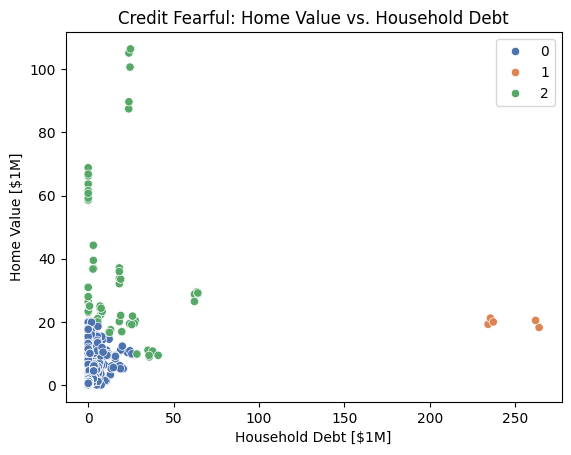

In [37]:
# Plot "HOUSES" vs "DEBT" with hue=label
sns.scatterplot(
    x=df["DEBT"]/1e6, 
    y=df["HOUSES"]/1e6,
    hue=labels,
    palette="deep"
)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

Extract Centrids

In [38]:
centroids = model.cluster_centers_
print("centroids type:", type(centroids))
print("centroids shape:", centroids.shape)
centroids

centroids type: <class 'numpy.ndarray'>
centroids shape: (3, 2)


array([[2.20310418e+05, 6.36156059e+05],
       [2.46598000e+08, 1.98020000e+07],
       [1.47308803e+07, 3.52538028e+07]])

Plot Centroids

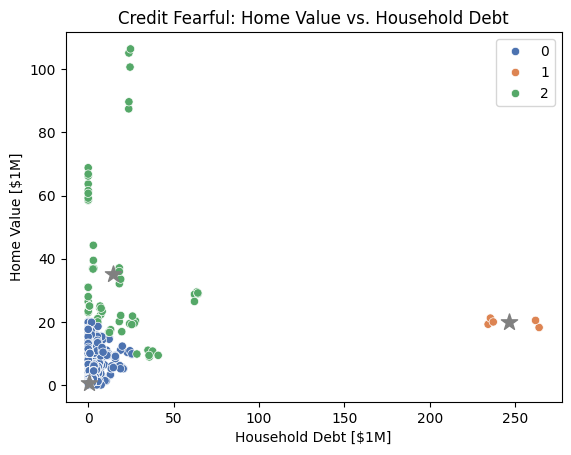

In [40]:
# Plot "HOUSES" vs "DEBT", add centroids
sns.scatterplot(
    x=df["DEBT"]/1e6, 
    y=df["HOUSES"]/1e6,
    hue=labels,
    palette="deep"
)
plt.scatter(
    x = centroids[:, 0]/1e6,
    y = centroids[:, 1]/ 1e6,
    color="grey",
    marker="*",
    s=150
)
plt.xlabel("Household Debt [$1M]")
plt.ylabel("Home Value [$1M]")
plt.title("Credit Fearful: Home Value vs. Household Debt");

Inertia

- Inertia is the distance between the points within the same cluster - measures how internally coherent your clusters are.

In [42]:
inertia = model.inertia_
print("inertia type:", type(inertia))
print("Inertia (3 clusters):", inertia)

inertia type: <class 'float'>
Inertia (3 clusters): 1.5359768081556496e+17


- Usually, the best inertia is 0, and our score is far from it but this does not necessarily mean that our model is bad.

- Not necessarily. Inertia is a measurement of distance (like mean absolute error). This means that the unit of measurement for inertia depends on the unit of measurement of our x- and y-axes. And since "DEBT" and "HOUSES" are measured in tens of millions of dollars, it's not surprising that inertia is so large.

- However, it would be helpful to have metric that was easier to interpret, and that's where silhouette score comes in. Silhouette score measures the distance between different clusters. It ranges from -1 (the worst) to 1 (the best), so it's easier to interpret than inertia. 

Silhouette Score

- While inertial measures internal consistency - the distance within clusters, silhouette score measures the distance between clusters.

- The best silhouette score is 1, and the worst is -1.

In [43]:
ss = silhouette_score(X, model.labels_)
print("ss type:", type(ss))
print("Silhouette Score (3 clusters):", ss)

ss type: <class 'numpy.float64'>
Silhouette Score (3 clusters): 0.9692959520939576


- This is the silhouette score for k = 3. The next step is to find the best k (clusters) that would give the best silhouette score.

Finding the best K

In [44]:
n_clusters = range(2,13)
inertia_errors = []
silhouette_scores = []

# Add `for` loop to train model and calculate inertia, silhouette score.
for k in n_clusters:
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertia_errors.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X, model.labels_))
    

print("inertia_errors type:", type(inertia_errors))
print("inertia_errors len:", len(inertia_errors))
print("Inertia:", inertia_errors)
print()
print("silhouette_scores type:", type(silhouette_scores))
print("silhouette_scores len:", len(silhouette_scores))
print("Silhouette Scores:", silhouette_scores)

inertia_errors type: <class 'list'>
inertia_errors len: 11
Inertia: [2.5338635630605645e+17, 1.5359768081556493e+17, 9.395661256674451e+16, 6.667853600572947e+16, 4.836688837150064e+16, 4.210737579261733e+16, 3.509084247015345e+16, 2.796098748562573e+16, 2.3338424513550664e+16, 2.1360049628595924e+16, 1.7305054372764422e+16]

silhouette_scores type: <class 'list'>
silhouette_scores len: 11
Silhouette Scores: [0.9945372723089505, 0.9692959520939576, 0.9186169521343938, 0.8991964707907557, 0.8416711186536293, 0.839261732725937, 0.8292092336453061, 0.8338117020203136, 0.7550318989637721, 0.6702574881699257, 0.6616311636182247]


- The next task is to make line plots to see the relationship between the number of clusters in a model and its inertia and silhouette scores.

Inertia vs Clusters

- A line plot showing the values of inertia_errors as a function of n_clusters.

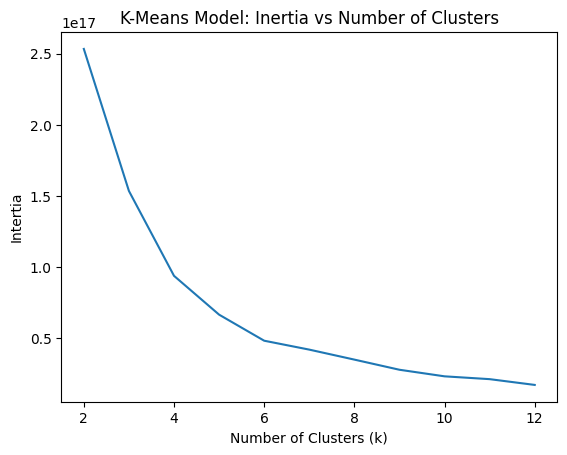

In [45]:
# Plot `inertia_errors` by `n_clusters`
plt.plot(n_clusters, inertia_errors);
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Intertia")
plt.title("K-Means Model: Inertia vs Number of Clusters");

- The graph shows that as the number of clusters increases, inertia goes down.

- The trick with choosing the right number of clusters is to look for the "bend in the elbow" for this plot - the point where the drop in inertia becomes less dramatic and the line begins to flatten out. In this case, it looks like the sweet spot is 4 or 5.

Silhouette Score vs Clusters

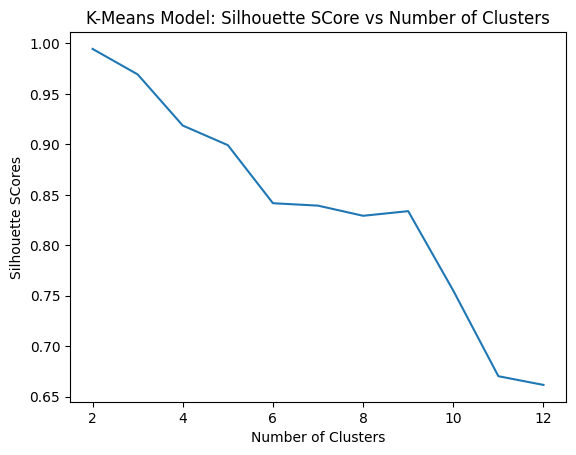

In [46]:
# Plot `silhouette_scores` vs `n_clusters`
plt.plot(n_clusters, silhouette_scores);
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette SCores")
plt.title("K-Means Model: Silhouette SCore vs Number of Clusters");

- We see that silhouette score drops drastically beyond 4 clusters. Given this and what we saw in the inertia plot, it looks like the optimal number of clusters is 4.

Build Final Model

In [48]:
# Build model
final_model = KMeans(n_clusters=4, random_state=42)
print("final_model type:", type(final_model))

# Fit model to data
final_model.fit(X)

final_model type: <class 'sklearn.cluster._kmeans.KMeans'>


KMeans(n_clusters=4, random_state=42)

In [49]:
# Assert that model has been fit to data
check_is_fitted(final_model)

### Communicate Results